### Example of Symbolic Regression to estimate LAI from spectral and structural data in vineyards

Data generated by Sergio Alvarez, GRAPEX project.

Utah State University, 2025.

File '03_df_bands_structure_VI_LAI_NDVIc.csv' contains as potential predictors
- Reflectance values from canopy
- Vegetation indices for canopy
- Geometric information (H, widht, etc) per vine
- two predictants (afc, LAI) in the last colunms.

In this example, we look to model LAI using reflectance and VIs generated by Symbolic Regression. So, we just give the form the the ND form = ((A-B)/(A+B)) and SR = A/B.

### Instructions
- if not, create a anaconda environment, e.g. 
```bash
conda create -n pysr
```
- once completed the step above in the pysr environment install these modules:
```bash
conda install pysr
conda install matplotlib
pip install skillmetrics
```
- final step, in the activated environment and pass this command:
```bash
- python -c "import pysr"
```
- last commands will install julia libraries, necessary to run the notebook.

- To visualize the results install Jinja2
```bash
conda install jinja2
```



### Running PySR 

Julia and Julia dependencies are installed at first import:

In [60]:
import pysr

Now, let's import everything else as well as the PySRRegressor:


In [61]:
import warnings
warnings.filterwarnings('ignore')

import sympy
import numpy as np
import pandas as pd
import skill_metrics as sm
import mpl_scatter_density # adds projection='scatter_density'

from pysr import PySRRegressor
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Set up PySR run:


using Sergio's data

In [62]:
df = pd.read_csv('03_df_bands_structure_VI_LAI_NDVIc.csv')
# print(df.head())
X = df.iloc[:,1:5]
y = df.iloc[:,-2]
print(y.head())

0    1.47
1    1.50
2    1.18
3    1.16
4    1.19
Name: LAI, dtype: float64


key pySR parameters to be changed:

In [63]:
niterations = 100  # for short runs, set this to a 100, for longer runs, set this to 10 million
timeout_in_seconds = 3600*2  # this line will make the code stop after 2 hours, change it as desired.
elementwise_loss = "L2DistLoss()"  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options

# binary_operators=["+", "*","-","/","^"], # these are the default binary operators (use these for basic equations)
binary_operators = ["+", "*","-","/","^","ND(x,y) = ((x-y)/(x+y))", "SR(x,y)=x/y"]  # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
unary_operators = ["sqrt", "exp", "log", "inv(x)=1/x"]  # other basic operators can be added here
extra_sympy_mappings = {"inv": lambda x: 1 / x,"ND": lambda x, y: ((x- y)/(x+y)),"SR": lambda x, y: x/y}  # here the format of the sought expressions are defined

The default parameters will help speed up code and ensure repeteability of run

In [64]:
default_pysr_params = dict(
    model_selection="best", #"score", "best", see documentation for more options
    random_state=0, # seed number to ensure reproducible results across different runs
    deterministic=True, #   to ensure reproducible results across different runs
    parallelism="serial", # to ensure reproducible results across different runs
    maxsize=50, # maximum complexity of the equations, increase to 100 for more complex equations, reduce to 20 for less complex equations   
    # select_k_features=10, # to automatically select few predictors (using random forest) from set of predictors, activate/deactive as you wish
    # denoise=True, # to remove scattering on y, activate/deactivate as you wish
    verbosity =0,   # 0 for no output, 1 for some output
    elementwise_loss= elementwise_loss,  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options
    )

In [65]:
# Learn equations
model = PySRRegressor(
    niterations=niterations,  # for short runs, set this to a 100, for longer runs, set this to 10 million
    timeout_in_seconds=timeout_in_seconds,  # this line will make the code stop after 2 hours
    binary_operators=binary_operators, # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
    unary_operators=unary_operators, # other basic operators can be added here
    extra_sympy_mappings=extra_sympy_mappings, # here the format of the sought expressions are defined
    turbo=True, # set to True to speed up the code 
    **default_pysr_params,
)

model.fit(X, y)


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           2.367226   
	1         0.126913                                SR(NIR, 0.16969956)   
	2         0.038825                        SR(0.76929736, Green ^ NIR)   
	3         0.041701                          NIR / (Green ^ sqrt(NIR))   
	4         0.041508                      SR(NIR, SR(Green, NIR)) - NIR   
	5         0.008006    ((NIR / 0.33158734) / sqrt(Green)) + -2.5802605   
	6         0.063198  -9.869617 - ((NIR + (Blue ^ Green)) * -10.475616)   
	7         0.030430  -11.425821 - ((((Blue ^ Green) - Blue) + NIR) ...   
	8         0.019726  (-7.625505 - (((NIR - Blue) + (Blue ^ Green)) ...   
	9         0.014095  (((Blue ^ (Blue + (Green ^ 0.8479769))) * (NIR...   
	10        0.022308  (((NIR - -0.19801173) * ((Blue ^ ((Blue + Gree...   
	11        0.023312  (((Blue ^ ((Green + Blue) ^ 0.5264923)) * (((N...   
	12        0.001293  (((Blue ^ ((Green + Blue) ^ 0.5264923)) * ((((...   
	13        0.007793  ((((((NIR - -0.23438723) - Blue) - Blue) * 39....   
	14  >>>>  0.150600  ((((Red ^ Green) + NIR) * ((SR(NIR / (Blue / R...   
	15        0.002858  Red + ((((NIR + (Red ^ Green)) * ((Red ^ Blue)...   
	16        0.001227  ((((Red ^ Blue) + ((NIR / (Blue / SR(Red, Blue...   
	17        0.002029  (sqrt(Red) + ((((Red ^ (Blue / 1.0243886)) + (...   
	18        0.000698  (sqrt(Red) + ((((SR(NIR, Blue / Red) / NIR) / ...   
	19        0.001090  (Red + (((((Red ^ (Blue * 1.0243886)) + ((SR(N...   
	20        0.142375  (((((Blue ^ Green) + NIR) * (sqrt(Red ^ Blue) ...   
	21        0.094854  ((((((NIR + (Blue ^ Green)) * ((((sqrt(Green) ...   
	22        0.003454  (((((Blue ^ Green) + NIR) * (12.819813 * (((SR...   
	
	        loss  complexity  
	0   1.291319           1  
	1   1.001839           3  
	2   0.926990           5  
	3   0.889128           6  
	4   0.852978           7  
	5   0.846176           8  
	6   0.794355           9  
	7   0.747453          11  
	8   0.718538          13  
	9   0.698565          15  
	10  0.668083          17  
	11  0.637649          19  
	12  0.636002          21  
	13  0.626167          23  
	14  0.463319          25  
	15  0.460679          27  
	16  0.459550          29  
	17  0.458618          30  
	18  0.457978          32  
	19  0.456483          35  
	20  0.395906          36  
	21  0.360079          37  
	22  0.356368          40  
]

We can print the model pareto curve, which will showcase the trend of discovered solutions:

In [66]:
best_score=model.get_best().score

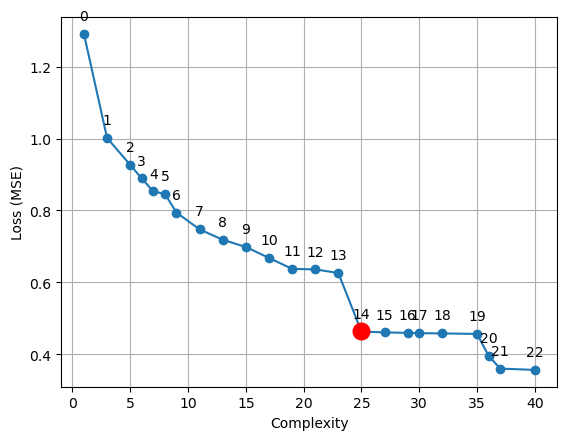

In [67]:
# best scoring equation (not the one with the lowest loss nor the one with the lowest complexity, but the one that optimally balances the two)
scores = model.equations_.score
# get the index of the first max
# max_index = scores.idxmax(axis=0)
max_index = scores == best_score
max_index


pareto =model.equations_.iloc[:, [0, 1]] # Print the equations found
# pareto
plt.plot(pareto.complexity,pareto.loss,'-o')
plt.plot(pareto.complexity[max_index],pareto.loss[max_index],'ro',markersize=12)
plt.grid(True)
plt.xlabel("Complexity")
plt.ylabel("Loss (MSE)")



ii=0
# zip joins x and y coordinates in pairs
for p,q, in zip(pareto.complexity,pareto.loss):

    label = "{:.0f}".format(ii)

    plt.annotate(label, # this is the text
                 (p,q), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ii=ii+1
plt.show()

We can also view the SymPy format of the equation of our interest:

In [68]:
unique_max_index = max_index[max_index].index.tolist()
model.sympy(unique_max_index[0])  # get the selected equation in sympy format

(NIR + Red**Green)*(Red**Blue + (Red/Blue)/((-15.359827/NIR)))*16.99988 - 1*15.14815

We can also view the form of any other expression in the list, using the index of it in `model.equations_`.

In [69]:
found_equations =model.equations_.iloc[:, [1,2]]  # print all the equations found
# pd.set_option('display.max_colwidth',200)  
# display(found_equations)

# Apply a color ramp to the 'Score' column
styled_df = found_equations.style.background_gradient(
    subset=['loss'],  # Column to apply gradient
    cmap='jet'      # Color map matplotlib colormap name
)

# Display in Jupyter Notebook
styled_df

,loss,equation
0,1.291319,2.367226
1,1.001839,"SR(NIR, 0.16969956)"
2,0.926990,"SR(0.76929736, Green ^ NIR)"
3,0.889128,NIR / (Green ^ sqrt(NIR))
4,0.852978,"SR(NIR, SR(Green, NIR)) - NIR"
5,0.846176,((NIR / 0.33158734) / sqrt(Green)) + -2.5802605
6,0.794355,-9.869617 - ((NIR + (Blue ^ Green)) * -10.475616)
7,0.747453,-11.425821 - ((((Blue ^ Green) - Blue) + NIR) * -11.955815)
8,0.718538,(-7.625505 - (((NIR - Blue) + (Blue ^ Green)) * -7.476034)) / NIR
9,0.698565,(((Blue ^ (Blue + (Green ^ 0.8479769))) * (NIR - -0.38811347)) * 20.632738) + -7.818391


## Output

Plotting the first solutions

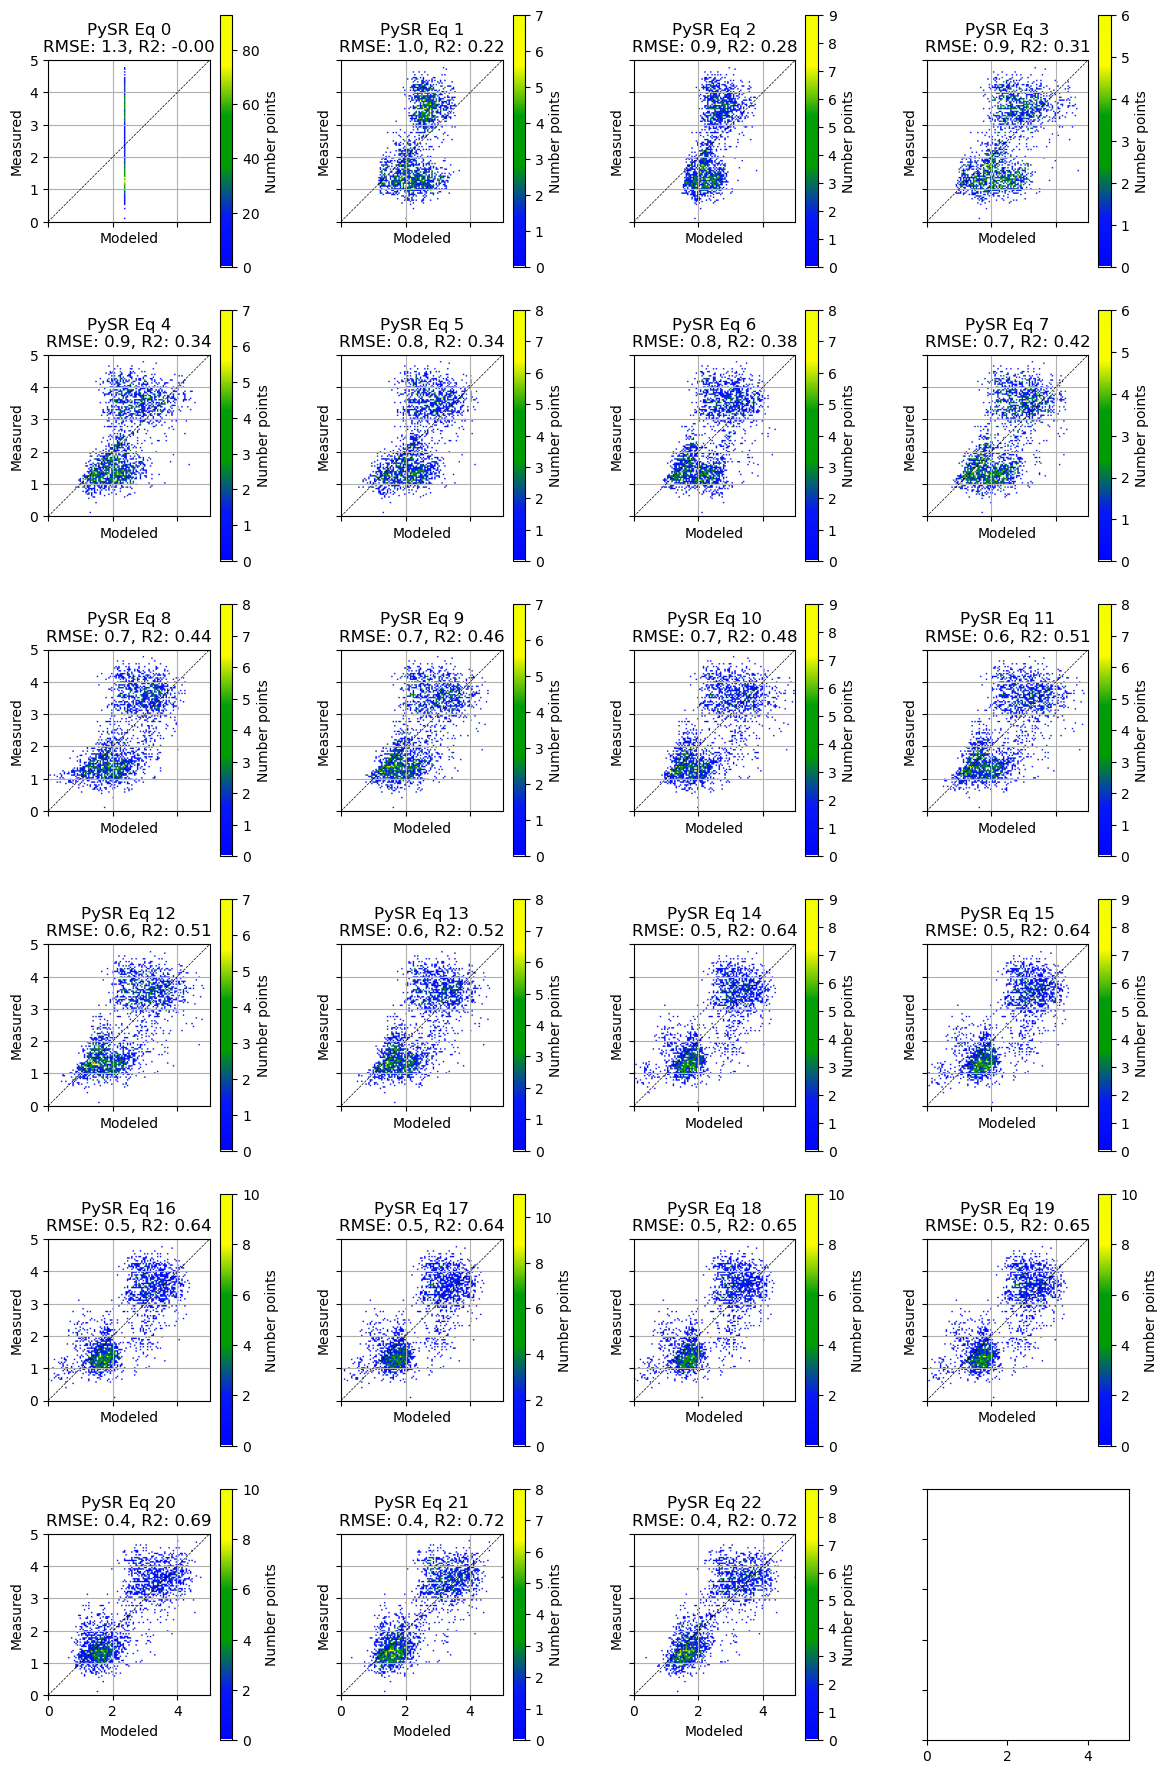

In [ ]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, "#0004FF"),
    (0.2, "#0818F6"),
    (0.4, "#009d00"),
    (0.6, "#009d0a"),
    (0.8, "#fcfc01"),
    (1, "#f2ff00"),
], N=256)

num_eq = len(model.equations_)

fig_rows = int(np.ceil(num_eq / 4))
fig_cols = 4

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True,subplot_kw=dict(projection="scatter_density"))

it = np.linspace(0,num_eq-1,num_eq, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    # ypredict_simpler = pd.Series(np.asarray(ypredict_simpler).ravel(), index=y.index)

    density=ax.scatter_density(ypredict_simpler, y, cmap=white_viridis)

    # ax.plot(ypredict_simpler, y,'.')

    ax.grid(True)
    ax.set_xlabel("Modeled")
    ax.set_ylabel("Measured")
    ax.plot( [0,5], [0,5], linestyle='--', color='k', linewidth=0.5 )
    fig.colorbar(density, label='Number points', ax=ax)

    ax.set_aspect('equal')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    mse = mean_squared_error(ypredict_simpler, y)
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nMSE: {mse:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

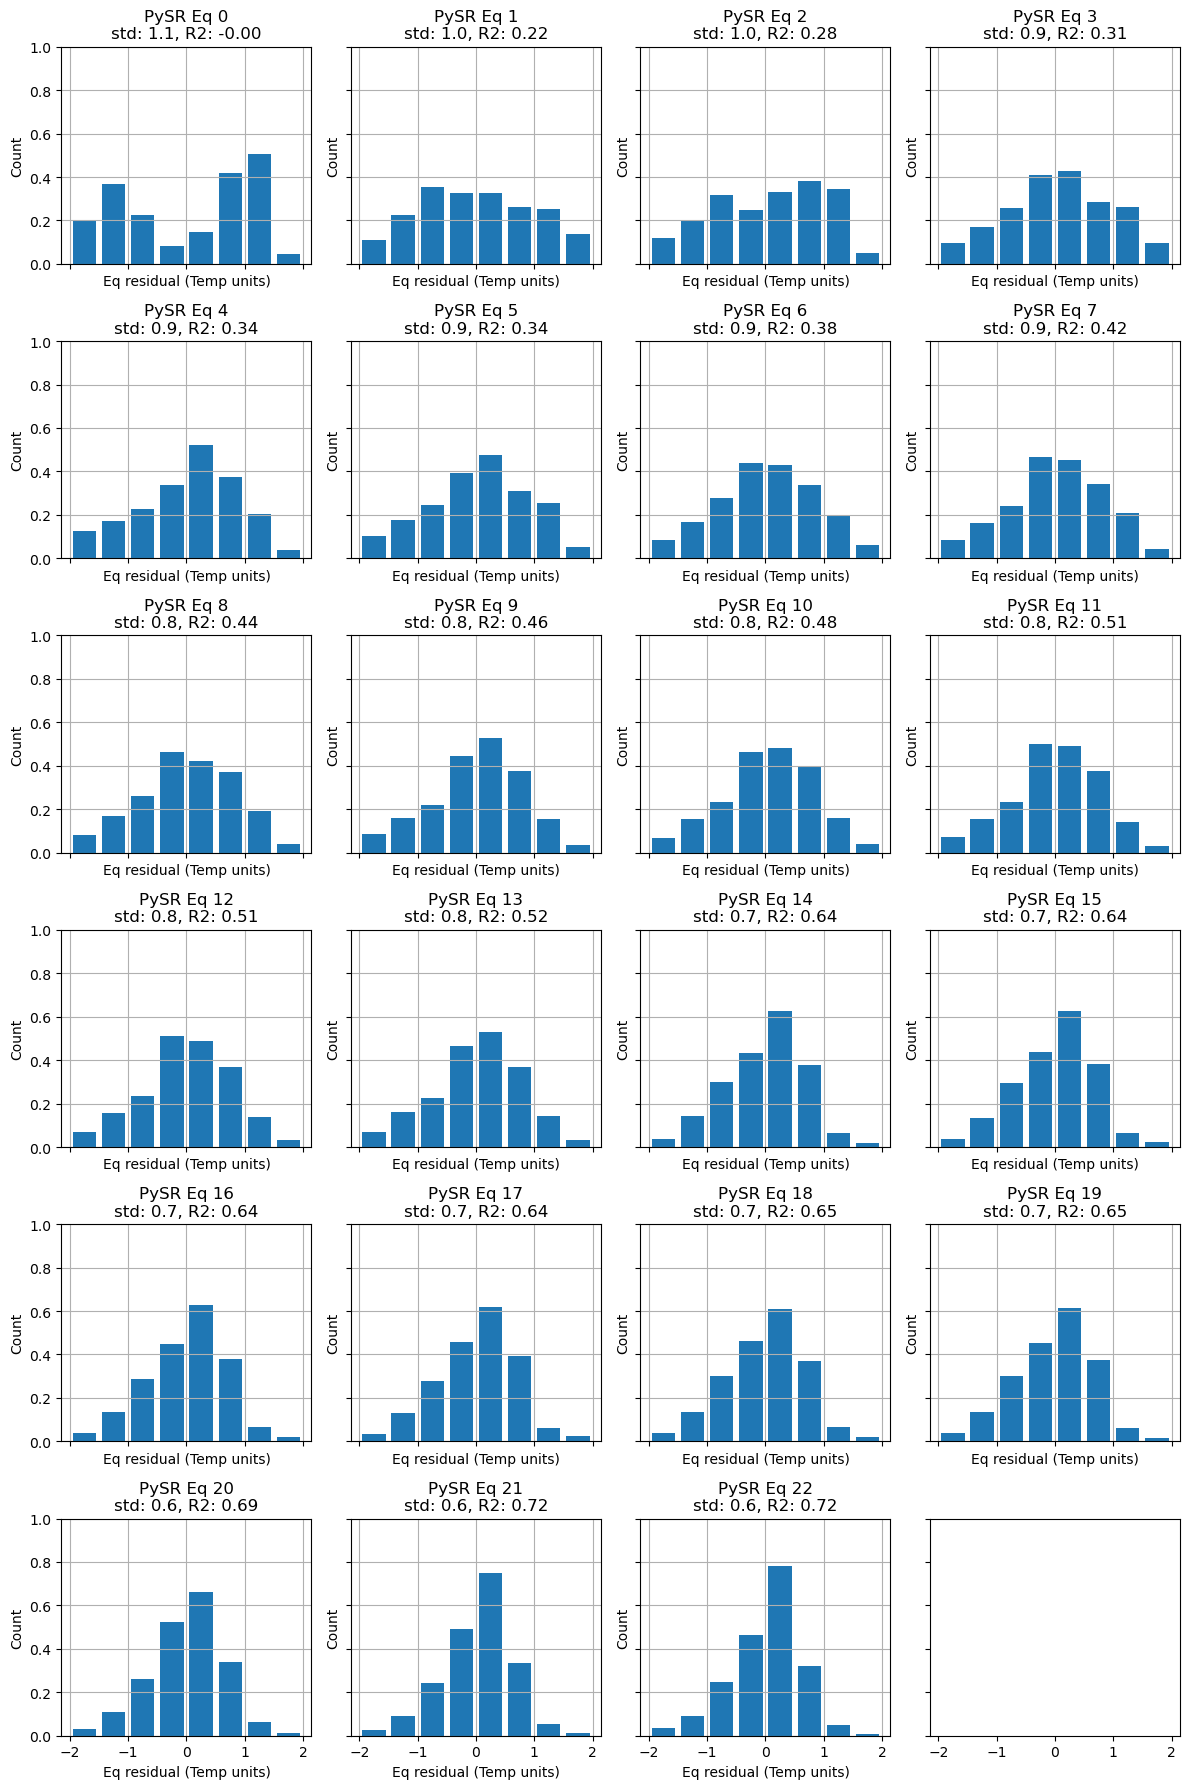

In [71]:
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True)

# Define bin interval and create bin edges
bin_interval = 0.5  # Adjust this value to change bin width
bins = np.arange(-2, 2 + bin_interval, bin_interval)

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.hist(ypredict_simpler- y, bins=bins, density=True, rwidth=0.8)
    ax.grid(True)
    ax.set_xlabel("Eq residual (var units)")
    ax.set_ylabel("Count")
    # ax.plot( [0,70], [0,70], linestyle='--', color='k' )
    ax.set_ylim(0, 1)

    N = len(y)
    mean = np.mean(ypredict_simpler - y)
    ddof = 1  # Use sample standard deviation
    d2 = abs(ypredict_simpler- y - mean)**2  # abs is for complex `a`
    var = d2.sum() / (N - ddof)  # note use of `ddof`
    std = var**0.5
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nstd: {std:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Create a Taylor diagram with labeled data points and modified axes

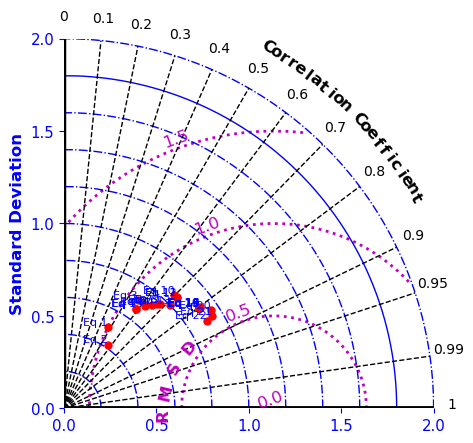

In [72]:
# number of equations found
n_e= len(found_equations)

it2 = np.linspace(0,n_e-1,n_e, dtype=int)  # Ensure indices are integers

# Prepare data for Taylor diagram
data = {}
# data=pd.DataFrame(data)

sdev = np.array([])
crmsd = np.array([])
ccoef = np.array([])

data['ref'] = y.values  # Store reference data in data dictionary
taylor_stats = sm.taylor_statistics(data['ref'],data['ref'])
sdev = np.append(sdev,[taylor_stats['sdev'][0]])
crmsd = np.append(crmsd,[taylor_stats['crmsd'][0]])
ccoef = np.append(ccoef,[taylor_stats['ccoef'][0]])

for i in it2:
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    data['pred'+str(i+1)] = ypredict_simpler  
    taylor_stats = sm.taylor_statistics(data['pred'+str(i+1)],data['ref'])
    sdev = np.append(sdev,[taylor_stats['sdev'][1]])
    crmsd = np.append(crmsd,[taylor_stats['crmsd'][1]])
    ccoef = np.append(ccoef,[taylor_stats['ccoef'][1]])
    
data = pd.DataFrame(data)
data

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Reference'] + ['Eq ' + str(i) for i in it2]    

# Produce the Taylor diagram

#     Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                                   [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'b', 
                      tickRMS= np.arange(0,2,0.5),
                      tickRMSangle = 110.0, 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      tickSTD = np.arange(0,2,0.2), axismax = 2.0, 
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)
# plt.title('Taylor Diagram of Drone Thermal Camera Correction Models', fontsize=16)


# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api